In [2]:
import numpy as np
import re
import string
import nltk
import string
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics.pairwise as smp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
nltk.download('stopwords')
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
from timeit import default_timer as timer
from datetime import timedelta
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

In [0]:
# Dataset is now stored in a Pandas Dataframe
path = "/content/drive/My Drive/data/author.csv"
df_author = pd.read_csv(path)
df_author.columns = ['unnamed','id','title','authors','authors_id','issued_time','nber_programs','Abstract','author1_id','coauthor_id','unnamed_10','author1-gender','author1_lname','author1_fname','co-number','co_lname','co-gender','co-fname']

In [0]:
df_men = df_author.loc[(df_author['author1-gender']== 0)]
df_women = df_author.loc[(df_author['author1-gender']== 1)]
# df_men = df_author.loc[(df_author['author1-gender']== 0) & (df_author['co-number'] == 2) & (df_author['co-gender'] == 0)]
# df_women = df_author.loc[(df_author['author1-gender']== 1) & (df_author['co-number'] == 2) & (df_author['co-gender'] == 1)]
# df_men = df_author.loc[(df_author['author1-gender']== 0) & (df_author['co-Number'] == 2) & (df_author['co-gender'] == 0)]
# df_women = df_author.loc[(df_author['author1-gender']== 1)]
df_men.reset_index(level=0, inplace=True)
df_women.reset_index(level=0, inplace=True)

In [218]:
len(df_men)

24918

###Helper functions for analyze the data

In [0]:
# clean the words by eliminate the numbers, the outputs are in lower cases
def clean_words(sentence):
    words = sentence.lower().split()  
    result = [re.sub("[^a-zA-Z]","", word) for word in words]
    return result

In [0]:
#function for data display
from itertools import product
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

In [0]:
#words stemming
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
sno = SnowballStemmer('english')
def root(words):
  cleanedword = []
  for w in words:
    cleanedword.append(sno.stem(w))
  return cleanedword 

In [0]:
# clean the vocabulary from all the authors and store the words by gender seprately in the list
import operator
abstract_male = []
abstract_female = []
ll = len(df_women.Abstract)
l = len(df_men.Abstract)
for i in range(l):
  sentence_clean = clean_words(df_men.Abstract[i])
  sentencem = root(sentence_clean)
  abstract_male.extend(sentencem)
for j in range(ll):
  sentence_cleanf = clean_words(df_women.Abstract[j])
  sentencef = root(sentence_cleanf)
  abstract_female.extend(sentencef)

In [0]:
#matrix of words
def bag_of_words(sentence, words):
    sentence_words = clean_words(sentence)
    # frequency word count
    bag = np.zeros(len(words))
    for sw in sentence_words:
        for i,word in enumerate(words):
            if word == sw: 
                bag[i] += 1
                
    return np.array(bag)

###Clean the wording for both male and female and save them in csv for analyzing in R

In [0]:
main_dic = []
for word in abstract_female:
  main_dic.append(word)
for word in abstract_male:
  main_dic.append(word)
  
main_dic = list(set(main_dic))

In [0]:
word_count_f = {x:0 for x in main_dic}
word_count_m = {x:0 for x in main_dic}

In [0]:
# count the number of words from female
for word in abstract_female:
  word_count_f[word] += 1  
for word in abstract_male:
  word_count_m[word] += 1

In [0]:
word_count_combined = { word : (word_count_f[word] + word_count_m[word]) for word in word_count_f }

In [0]:
low_freq_word = [word for word in word_count_combined if word_count_m[word] <= 5]

In [51]:
len(word_count_combined) - len(low_freq_word)

9361

In [0]:
word_count_f_no_lowfreq = { word : word_count_f[word] for word in word_count_f if word not in low_freq_word}
word_count_m_no_lowfreq = { word : word_count_m[word] for word in word_count_m if word not in low_freq_word}

In [0]:
word_count_f_no_lowfreq_list = [ [k,v] for k, v in word_count_f_no_lowfreq.items() ]
word_count_m_no_lowfreq_list = [ [k,v] for k, v in word_count_m_no_lowfreq.items() ]

In [0]:
df_female = pd.DataFrame(word_count_f_no_lowfreq_list, columns = ['Word' , 'FemaleFrequency'])
df_male = pd.DataFrame(word_count_m_no_lowfreq_list, columns = ['Word' , 'MaleFrequency'])

In [0]:
df_male.head()

In [0]:
df_female.head()

In [0]:
df_combined = pd.merge(df_female, df_male, on='Word')

In [0]:
df_combined

###Use Chi-square test to eliminat the words


In [0]:
path = "/content/drive/My Drive/data/chi-square-stat.csv"
df_chi = pd.read_csv(path)

In [149]:
len(df_chi)

9360

In [0]:
df_chi_f = df_chi["FemaleFrequency"].tolist()
df_chi_m = df_chi["MaleFrequency"].tolist()
df_word = df_combined["Word"].tolist()[1:]

In [0]:
chi_sq_list = [df_word,df_chi_f,df_chi_m]

chi_sq_list = list(map(list, zip(*chi_sq_list)))



In [0]:
df_chi_square = pd.DataFrame(chi_sq_list, columns=['Words', 'chi_f', 'chi_m'])

In [0]:
df_good = df_chi_square.loc[(df_chi_square['chi_f']>= 0.01) | (df_chi_square['chi_m']>= 0.01)]

In [0]:
goodwords = df_good["Words"].tolist()
goodwords

###Analysis the data using bag of words

In [0]:
import random
bow_random = []
for i in range(l):
  bow_random.append(bag_of_words(df_men.Abstract[i], goodwords))

In [0]:
from random import shuffle
shuffle(bow_random)
bow_random_selected = random.sample(bow_random,5669)

In [0]:
Y = []
for i in range(5669):
  Y.append(1)
for j in range(5669):
  Y.append(0)

In [0]:
for i in range(ll):
  bow_random_selected.append(bag_of_words(df_women.Abstract[i], goodwords))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(bow_random_selected, Y, test_size=0.1, random_state=0)

In [0]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

In [244]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[378, 204],
       [180, 372]])

In [0]:
# Compute confusion matrixcnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrixplt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Negative','Positive'],
                      title='Confusion matrix, without normalization')

In [216]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  378
False Positives:  204
False Negatives:  180
True Positives:  372


In [217]:
#Accuracy
Accuracy_all = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy_all {:0.2f}%:".format(Accuracy_all))

Accuracy_all 66.14%:


In [0]:
y_pred=logreg.predict()

###Predit all the data

In [0]:
Y1 = []
for i in range(24918):
  Y1.append(1)
for j in range(5669):
  Y1.append(0)

In [0]:
for i in range(ll):
  bow_random.append(bag_of_words(df_women.Abstract[i], goodwords))

In [0]:
# instantiate the model (using the default parameters)

y_pred=logreg.predict(bow_random)

In [247]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(Y1, y_pred)
cnf_matrix

array([[ 3821,  1848],
       [ 7745, 17173]])

Confusion matrix, without normalization
[[ 3821  1848]
 [ 7745 17173]]


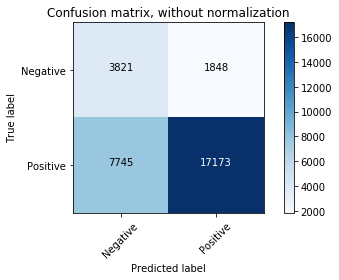

In [248]:
# Compute confusion matrixcnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrixplt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Negative','Positive'],
                      title='Confusion matrix, without normalization')

In [253]:
tn, fp, fn, tp = metrics.confusion_matrix(Y1, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  3821
False Positives:  1848
False Negatives:  7745
True Positives:  17173


In [260]:
#Precision
#Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive.
Accuracy_all = (tp)*100/(tp+fp) 
print("Precision {:0.2f}%:".format(Accuracy_all))

Precision 90.28%:


In [258]:
#Recall
#Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive).
Accuracy = (tp)*100/(tp+fn) 
print("Recall {:0.2f}%:".format(Accuracy))

Recall 68.92%:


In [261]:
Accuracyy = (Accuracy_all*Accuracy)/(Accuracy_all+Accuracy)
print("F1 {:0.2f}%:".format(Accuracyy))

F1 39.08%:
